In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import os

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental import preprocessing
from google.colab import files


url = "https://raw.githubusercontent.com/MariaRevili/FYS-STK4155/master/Project3/eyeData.csv"
data = pd.read_csv(url)
data = data.iloc[:, 1:]
X = data.iloc[:, 0:14]
y = data.iloc[:, 14]
data = pd.DataFrame(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
np.random.seed(20)


Test MSE =  76.28446197509766
Accuracy =  0.9325767755508423


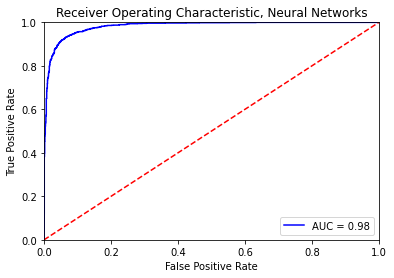

In [20]:
# Neural Network on original data

epochs = 1200
batch_size = 100
n_neurons_layer1 = 100
eta_vals = np.logspace(-5, 0, 5)
lmbd_vals = np.logspace(-5, 0, 5)

def neural_network_keras(n_neurons_layer1, eta, lmbd):  ##Build the model
    
    model = Sequential()
    model.add(Dense(n_neurons_layer1, activation='relu', kernel_regularizer=None))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  ##try adam also
    
    return model

DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
  
def train_dnn():    ##fit for different learning rate and decay (lambda) 
     
    for i, eta in enumerate(eta_vals):
        
        for j, lmbd in enumerate(lmbd_vals):
            
            DNN = neural_network_keras(n_neurons_layer1, 
                                            eta=eta, lmbd=lmbd)
            DNN.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0) ##what is verbose?
            y_pred = DNN.predict_classes(X_test)
            scores = DNN.evaluate(X_test, y_test, verbose=1)
            
            DNN_keras[i][j] = DNN
            
            print("Learning rate = ", eta)
            print("Lambda = ", lmbd)
            print("Test MSE = ", scores)
            print()  
  
#train_dnn()  

# Show the accuracy after training neural networks

DNN = neural_network_keras(n_neurons_layer1, 
                           eta=0.15, lmbd=0)
DNN.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0)
y_pred = DNN.predict_classes(X_test)
scores = DNN.evaluate(X_test, y_test, verbose=0)
print("Test MSE = ", scores[0])
print("Accuracy = ", scores[1])


### Plot the ROC curve
y_pred_prob = DNN.predict_proba(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic, Neural Networks')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig(os.path.join(os.path.dirname(__file__), '..', 'Plots', 'roc_nn.png'), transparent=True, bbox_inches='tight')
plt.show()

Accuracy: 0.9479305740987984


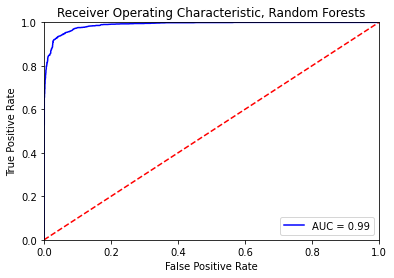

In [21]:
# Random forests 

rf=RandomForestClassifier(n_estimators=500, bootstrap=False) ##Number of Trees to build
rf.fit(X_train, y_train)
y_rf_predict = rf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_rf_predict))

X_train = pd.DataFrame(X_train)
## Visualize
# tree.plot_tree(rf.estimators_[0], feature_names=X_train.columns, filled=True)
# plt.show()


###Plot the ROC curve
y_pred_prob = rf.predict_proba(X_test)
y_pred_prob = y_pred_prob[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic, Random Forests')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

94/94 [==============================] - 0s 1ms/step - loss: 0.1754 - accuracy: 0.9466
Test MSE =  0.17543555796146393
Accuracy =  0.9465954899787903


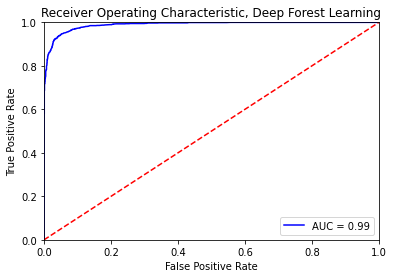

In [22]:
# Deep Forest Learning

### Obtain predictions from each weak tree and then use these predictions as covariates for neural networks
pred_train = np.ones((y_train.size, 1))
pred_test = np.ones((y_test.size, 1))


rf=RandomForestClassifier(n_estimators=500, bootstrap=False) ##Number of Trees to build
rf.fit(X_train, y_train)

for treeEst in rf.estimators_:
    per_tree_pred_tr = treeEst.predict(X_train).reshape(-1,1)
    per_tree_pred_te = treeEst.predict(X_test).reshape(-1,1)
    pred_train = np.c_[pred_train, per_tree_pred_tr]
    pred_test = np.c_[pred_test, per_tree_pred_te]


pred_train = pd.DataFrame(pred_train)
pred_train = pred_train.iloc[:, 1:]

pred_test = pd.DataFrame(pred_test)
pred_test = pred_test.iloc[:, 1:]


####Feed these predicted values (on the test data) instead of 
# original covariates into neural networks, estimate accuracy on the train data



epochs = 500
batch_size = 100
n_neurons_layer1 = 100
eta_vals = np.logspace(-5, 0, 5)
lmbd_vals = np.logspace(-5, 0, 5)

def neural_network_keras(n_neurons_layer1, eta, lmbd):  ##Build the model
    
    model = Sequential()
    model.add(Dense(n_neurons_layer1, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])  ##try adam also
    
    return model

DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
  

##Tune the parameters
def train_dnn():    ##fit for different learning rate and decay (lambda) 
     
    for i, eta in enumerate(eta_vals):
        
        for j, lmbd in enumerate(lmbd_vals):
            
            DNN = neural_network_keras(n_neurons_layer1, 
                                            eta=eta, lmbd=lmbd)
            DNN.fit(pred_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0) 
            y_pred = DNN.predict_classes(pred_test)
            scores = DNN.evaluate(pred_test, y_test, verbose=0)
            
            DNN_keras[i][j] = DNN
            
            print("Learning rate = ", eta)
            print("Lambda = ", lmbd)
            print("Test MSE = ", scores)
            print()  
  
#train_dnn()  


## Show the accuracy after training

DNN = neural_network_keras(n_neurons_layer1, 
                           eta=1, lmbd=0.003)
DNN.fit(pred_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0) 
y_pred = DNN.predict_classes(pred_test)
scores = DNN.evaluate(pred_test, y_test, verbose=1)
print("Test MSE = ", scores[0])
print("Accuracy = ", scores[1])

## Plot the ROC curve

y_pred_prob = DNN.predict_proba(pred_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic, Deep Forest Learning')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy: 0.7710280373831776


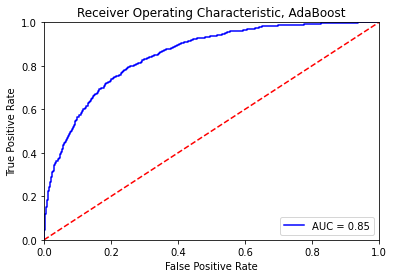

In [23]:
# AdaBoost

max_depth = 1
ab = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=max_depth), n_estimators=500)
ab.fit(X_train, y_train)
y_ab_predict = ab.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_ab_predict))

###Plot the ROC curve
y_pred_prob = ab.predict_proba(X_test)
y_pred_prob = y_pred_prob[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic, AdaBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("AdaBoost_ROC.png")
plt.show()

Accuracy: 0.9259012016021362

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

94/94 [==============================] - 0s 1ms/step - loss: 0.3208 - accuracy: 0.9329
Test MSE =  0.3208198547363281
Accuracy =  0.9329105615615845


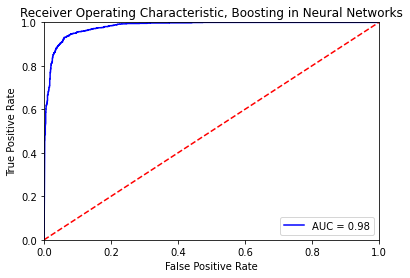

In [24]:
# Boosting Neural Networks

max_depth = 3
ab=AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=max_depth), n_estimators=500) ##Number of Trees to build
ab.fit(X_train, y_train)
y_ab_predict = ab.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_ab_predict))

pred_train = np.ones((y_train.size, 1))
pred_test = np.ones((y_test.size, 1))


##predict from each tree
for treeEst in ab.estimators_:
    per_tree_pred_tr = treeEst.predict(X_train).reshape(-1,1)
    per_tree_pred_te = treeEst.predict(X_test).reshape(-1,1)
    pred_train = np.c_[pred_train, per_tree_pred_tr]
    pred_test = np.c_[pred_test, per_tree_pred_te]


pred_train = pd.DataFrame(pred_train)
pred_train = pred_train.iloc[:, 1:]

pred_test = pd.DataFrame(pred_test)
pred_test = pred_test.iloc[:, 1:]


####Feed these predicted values (on the test data) instead of 
# original covariates into neural networks, estimate accuracy on the train data



epochs = 500
batch_size = 100
n_neurons_layer1 = 100
eta_vals = np.logspace(-5, 0, 5)
lmbd_vals = np.logspace(-5, 0, 5)

def neural_network_keras(n_neurons_layer1, eta, lmbd):  ##Build the model
    
    model = Sequential()
    model.add(Dense(n_neurons_layer1, activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])  ##try adam also
    
    return model

DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
  

##Tune the parameters
def train_dnn():    ##fit for different learning rate and decay (lambda) 
     
    for i, eta in enumerate(eta_vals):
        
        for j, lmbd in enumerate(lmbd_vals):
            
            DNN = neural_network_keras(n_neurons_layer1, 
                                            eta=eta, lmbd=lmbd)
            DNN.fit(pred_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0) 
            y_pred = DNN.predict_classes(pred_test)
            scores = DNN.evaluate(pred_test, y_test, verbose=0)
            
            DNN_keras[i][j] = DNN
            
            print("Learning rate = ", eta)
            print("Lambda = ", lmbd)
            print("Test MSE = ", scores)
            print()  
  
#train_dnn()  


## Show the accuracy after training

DNN = neural_network_keras(n_neurons_layer1, 
                           eta=1, lmbd=1e-5)
DNN.fit(pred_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0) 
y_pred = DNN.predict_classes(pred_test)
scores = DNN.evaluate(pred_test, y_test, verbose=1)
print("Test MSE = ", scores[0])
print("Accuracy = ", scores[1])


###Plot the ROC curve
y_pred_prob = DNN.predict_proba(pred_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)


#AdaBoost_ROC
plt.title('Receiver Operating Characteristic, Boosting in Neural Networks')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()